In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
consDF = pd.read_parquet("/uss/hdsi-prismdata/q2-ucsd-consDF.pqt")
consDF = consDF.drop(columns = ["credit_score"])
consDF = consDF.dropna()
acctDF = pd.read_parquet("/uss/hdsi-prismdata/q2-ucsd-acctDF.pqt")
trxnDF = pd.read_parquet("/uss/hdsi-prismdata/q2-ucsd-trxnDF.pqt")
catmap = pd.read_csv("/uss/hdsi-prismdata/q2-ucsd-cat-map.csv")

In [3]:
trxnDF.head()

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,3023,0,4,0.05,CREDIT,2021-04-16
1,3023,1,12,481.56,CREDIT,2021-04-30
2,3023,2,4,0.05,CREDIT,2021-05-16
3,3023,3,4,0.07,CREDIT,2021-06-16
4,3023,4,4,0.06,CREDIT,2021-07-16


In [4]:
acctDF.head()

,prism_consumer_id,prism_account_id,account_type,balance_date,balance
0,3023,0,SAVINGS,2021-08-31,90.57
1,3023,1,CHECKING,2021-08-31,225.95
2,4416,2,SAVINGS,2022-03-31,15157.17
3,4416,3,CHECKING,2022-03-31,66.42
4,4227,4,CHECKING,2021-07-31,7042.90


In [5]:
trxnDF["signed_amount"] = np.where(
    trxnDF["credit_or_debit"] == "CREDIT",
    trxnDF["amount"],
    -trxnDF["amount"]
)

In [6]:
# net transactions per consumer
txn_sum = (
    trxnDF
    .groupby("prism_consumer_id", as_index=False)["signed_amount"]
    .sum()
    .rename(columns={"signed_amount": "total_transactions"})
)

In [7]:
# initial balance for each consumer
initial_balance = (
    acctDF
    .groupby("prism_consumer_id", as_index=False)["balance"]
    .sum()
    .rename(columns={"balance": "initial_balance"})
)

In [9]:
# final balance for each consumer
final_balance = (
    initial_balance
    .merge(txn_sum, on="prism_consumer_id", how="left")
    .fillna({"total_transactions": 0})
)

final_balance["final_balance"] = (
    final_balance["initial_balance"] +
    final_balance["total_transactions"]
)

final_balance

,prism_consumer_id,initial_balance,total_transactions,final_balance
0,0,320.37,-521.59,-201.22
1,1,3302.42,1805.43,5107.85
2,10,824.24,-1190.04,-365.80
3,100,2655.47,-4505.77,-1850.30
4,1000,95.25,438.08,533.33
...,...,...,...,...
13004,9995,0.00,-121.55,-121.55
13005,9996,252.67,9.14,261.81
13006,9997,611.28,503.19,1114.47
13007,9998,-862.99,-833.10,-1696.09


In [10]:
final_balance[["initial_balance", "final_balance"]].describe()

,initial_balance,final_balance
count,1.300900e+04,1.300900e+04
mean,8.079853e+03,1.003303e+04
std,5.306647e+04,7.794515e+04
min,-9.261490e+03,-4.203443e+05
25%,3.251800e+02,3.805000e+01
50%,1.355610e+03,1.445600e+03
75%,4.953660e+03,6.289820e+03
max,3.598370e+06,5.952758e+06


In [26]:
# number of consumers with <0 initial balance 
(final_balance["initial_balance"] < 0).sum()

369

In [25]:
# number of conumers with <0 final balance
(final_balance["final_balance"] < 0).sum()

2921

In [27]:
# consumers that went from positive to negative balance
(
    (final_balance["initial_balance"] >= 0) &
    (final_balance["final_balance"] < 0)
).sum()

2613

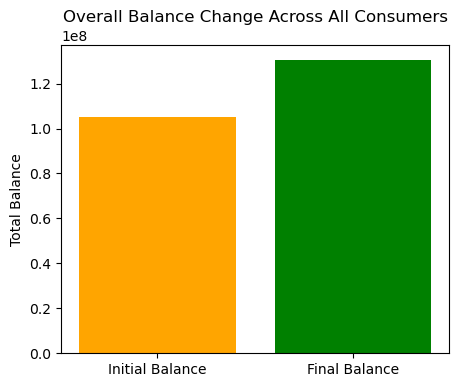

In [11]:
total_initial = final_balance["initial_balance"].sum()
total_final = final_balance["final_balance"].sum()

# Create a simple plot
plt.figure(figsize=(5,4))
plt.bar(["Initial Balance", "Final Balance"], [total_initial, total_final], color=["orange", "green"])
plt.ylabel("Total Balance")
plt.title("Overall Balance Change Across All Consumers")
plt.show()

/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


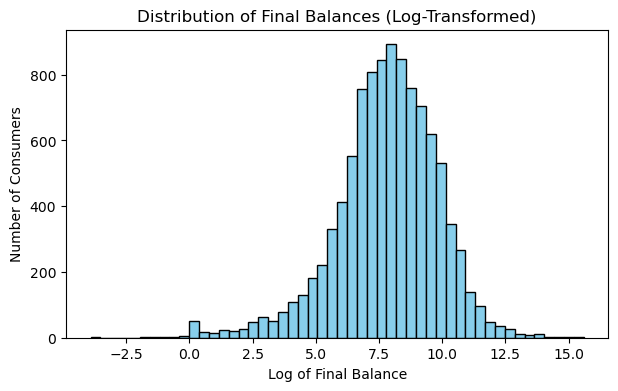

In [12]:
final_balance["final_balance_log"] = np.log1p(final_balance["final_balance"])

plt.figure(figsize=(7,4))
plt.hist(final_balance["final_balance_log"], bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Log of Final Balance")
plt.ylabel("Number of Consumers")
plt.title("Distribution of Final Balances (Log-Transformed)")
plt.show()

/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


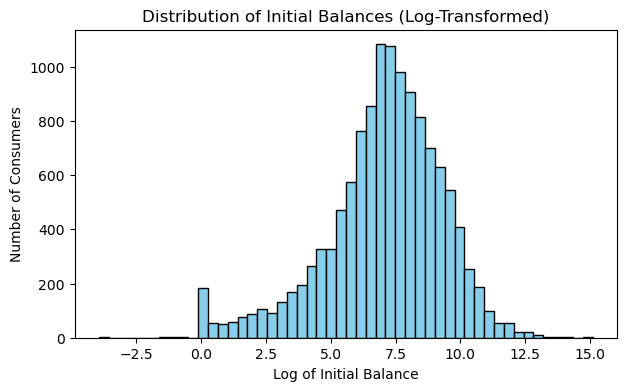

In [14]:
final_balance["initial_balance_log"] = np.log1p(final_balance["initial_balance"])

plt.figure(figsize=(7,4))
plt.hist(final_balance["initial_balance_log"], bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Log of Initial Balance")
plt.ylabel("Number of Consumers")
plt.title("Distribution of Initial Balances (Log-Transformed)")
plt.show()

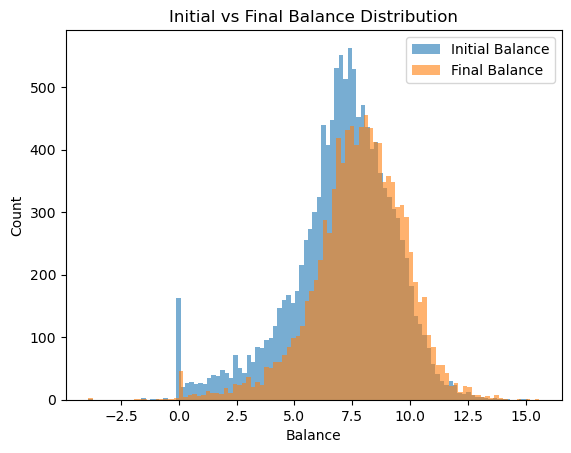

In [31]:
plt.figure()
plt.hist(
    final_balance["initial_balance_log"],
    bins=100,
    alpha=0.6,
    label="Initial Balance"
)
plt.hist(
    final_balance["final_balance_log"],
    bins=100,
    alpha=0.6,
    label="Final Balance"
)
plt.xlabel("Balance")
plt.ylabel("Count")
plt.title("Initial vs Final Balance Distribution")
plt.legend()
plt.show()